In [4]:
#clalify the google drive path
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#import things to use / define the functions to use
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time as tm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'


In [6]:
#1. check how we extracted the velocity of a player
time_test = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/explore-shottracker/timeseries/M_17472065-4ad8-11ea-9084-0242bdc61da9/M_17472065-4ad8-11ea-9084-0242bdc61da9_playerLocations.csv", 
                        sep=",", nrows=1000000) #first rows as an example


#for now, focus on a single player in a single game, short time
import numpy as np
df = time_test[time_test.playerID==67348]

tm = np.array(df.timestamp)
dt = (tm - np.array([tm[0]] + list(tm[:-1]))) /10**3
#calculate dp (position) [m]
x = np.array(df.X)
y = np.array(df.Y)
x_before = np.array([x[0]] + list(x[:-1]))
y_before = np.array([y[0]] + list(y[:-1]))
dp = np.sqrt( (x - x_before)**2 + (y - y_before)**2 ) /10**3
#v = dp / dt [m/s]
v = np.array(dp/dt)
#filter out the head, concat with the df
df = df.iloc[1:,:]
df["v"] = v[1:]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


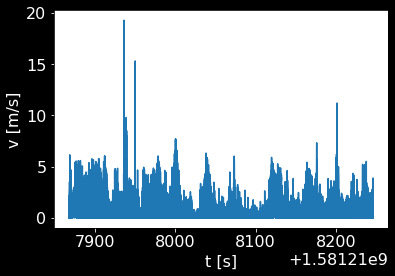

In [7]:
from matplotlib import pyplot as plt
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'black'

plt.plot(df.timestamp/10**3, v[1:])
plt.xlabel("t [s]")
plt.ylabel("v [m/s]")
plt.show()


In [8]:
#smooth it out
min_speed=3
df.index = df.timestamp
dfroll = df[["timestamp","v", "X", "Y"]].rolling(window=100).mean() #100 ~= 1s resolution 
vroll = np.array(dfroll.v)

#annotate the action moment
vroll_before = np.array([vroll[0]] + list(vroll[:-1]))
action_started = np.array((vroll>=min_speed)&(vroll_before<min_speed)) #when >=3m/s
action_ended = np.array((vroll<min_speed)&(vroll_before>=min_speed)) #when < than 3m/s
dfroll["action_started"] = action_started
dfroll["action_ended"] = action_ended


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


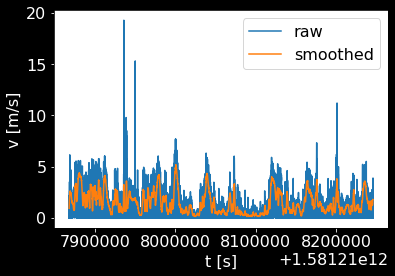

In [9]:
#overlay the smoothed speed

plt.plot(df.timestamp, df.v, label="raw")
plt.plot(dfroll.timestamp, dfroll.v, label="smoothed")
plt.xlabel("t [s]")
plt.ylabel("v [m/s]")
plt.legend()
plt.show()


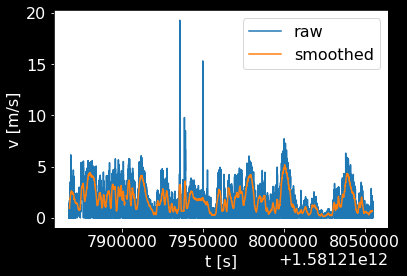

In [10]:
#focus on the first 3 min
headind = int(180*10**3/8)
plt.plot(df.head(headind).timestamp, df.head(headind).v, label="raw")
plt.plot(dfroll.head(headind).timestamp, dfroll.head(headind).v, label="smoothed")
plt.xlabel("t [s]")
plt.ylabel("v [m/s]")
plt.legend()
plt.show()


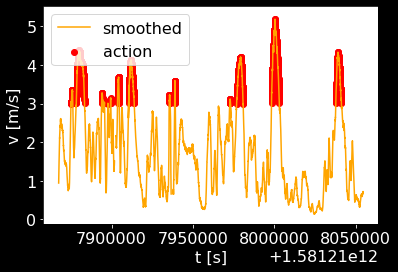

In [11]:
#annotate the start / end of action
dfsmall = dfroll.head(headind)
plt.plot(dfroll.head(headind).timestamp, dfroll.head(headind).v, label="smoothed", color="orange")
plt.scatter(dfsmall[dfsmall.v>3].timestamp, dfsmall[dfsmall.v>3].v, label="action", color="red")
plt.xlabel("t [s]")
plt.ylabel("v [m/s]")
plt.legend()
plt.show()

#we actually do off-the ball  /  min action length filtering in the pipeline, but will not show here for the time sake

In [0]:
#next, investigate the number of actions per player
heads = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/explore-shottracker/timeseries/M_17472065-4ad8-11ea-9084-0242bdc61da9/M_17472065-4ad8-11ea-9084-0242bdc61da9_playerLocations.csv", 
                        sep=",", nrows = 100000)
players = heads.playerID.unique()


action_num = {}
outpath_base = "/content/drive/My Drive/ssac_hackthon_2020/action_output_test/"
for player in  players:
    df = pd.read_csv(outpath_base+str(player)+"allchunk.tsv", sep="\t")
    action_num[player] = df.shape[0]



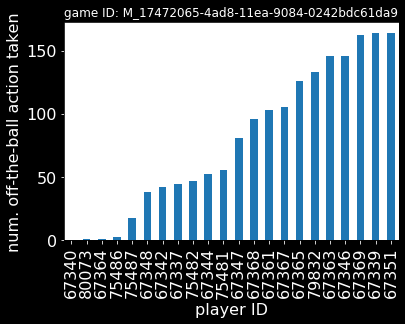

In [13]:
#distribution of the num. action
pd.Series(action_num).sort_values().plot.bar()
plt.title("game ID: M_17472065-4ad8-11ea-9084-0242bdc61da9", color="white", size=12)
plt.xlabel("player ID")
plt.ylabel("num. off-the-ball action taken")
plt.show()

In [0]:
#check the score:
scores = {}
for player in players:
    try:
      sc = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/play_output_test/action_scores_player{0}.tsv".format(player), sep="\t", index_col=0)
      scores[player] = sc.sum().values[0]
    except: 
      pass

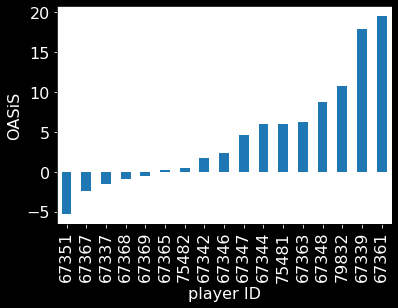

In [15]:
pd.Series(scores).sort_values().plot.bar()
plt.xlabel("player ID")
plt.ylabel("OASiS")
plt.show()

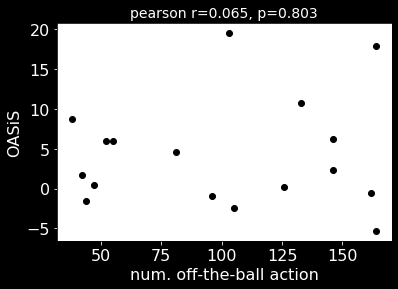

In [16]:
#correlation between action num. and OASiS
from scipy import stats
x = pd.Series(action_num)
y = pd.Series(scores)
xy = pd.concat([x,y], axis=1).dropna()
xy.columns = ["num action", "OASiS"]
pr, pval = stats.pearsonr(xy["num action"], xy["OASiS"])
plt.scatter(xy["num action"], xy["OASiS"], color="black")
plt.title("pearson r={0}, p={1}".format(str(pr)[:5], str(pval)[:5]), color="white", size=14)
plt.xlabel("num. off-the-ball action")
plt.ylabel("OASiS")
plt.show()

In [0]:
#compare this with simple number of assists / goals
events = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/explore-shottracker/playbyplay/M_17472065-4ad8-11ea-9084-0242bdc61da9.csv", sep=",")

In [0]:
events.dropna(subset=["PlayerId"], inplace=True)
events["playerID_int"] = events.PlayerId.astype(int)
agged = events.groupby("playerID_int")["FG3", "FG2", "AST"].agg("sum")
agged["goals"] = agged.FG3*3 + agged.FG2*2

In [0]:
agged = agged.iloc[1:,:]

In [0]:
oasis = pd.DataFrame(scores, index=["oasis"]).T

In [0]:
agged = agged.join(oasis)

In [24]:
agged.head()

,FG3,FG2,AST,goals,oasis
playerID_int,,,,,
67337,0.0,1.0,0.0,2.0,-1.5
67339,3.0,4.0,3.0,17.0,17.9
67342,0.0,1.0,0.0,2.0,1.7
67344,0.0,0.0,1.0,0.0,6.0
67346,1.0,1.0,2.0,5.0,2.4


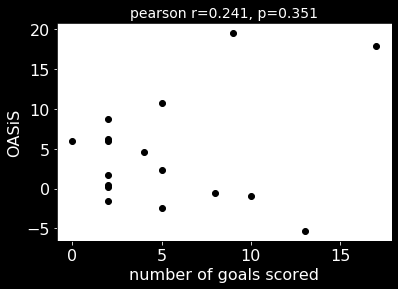

In [26]:
plt.scatter(agged.goals, agged.oasis, color="black")
pr, pval = stats.pearsonr(agged.goals, agged.oasis)
plt.title("pearson r={0}, p={1}".format(str(pr)[:5], str(pval)[:5]), color="white", size=14)
plt.xlabel("number of goals scored")
plt.ylabel("OASiS")
plt.show()

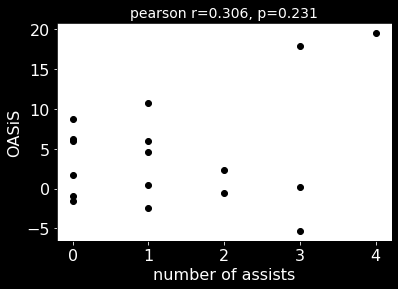

In [27]:
plt.scatter(agged.AST, agged.oasis, color="black")
pr, pval = stats.pearsonr(agged.AST, agged.oasis)
plt.title("pearson r={0}, p={1}".format(str(pr)[:5], str(pval)[:5]), color="white", size=14)
plt.xlabel("number of assists")
plt.ylabel("OASiS")
plt.show()

In [0]:
#overlay the events to the plot
#first, add event itself
events = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/play_output_test/M_17472065-4ad8-11ea-9084-0242bdc61da9_playscores.tsv", sep="\t")

In [29]:
dfsmall.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
m = dfsmall[dfsmall.action_started].timestamp.min()
M = dfsmall[dfsmall.action_started].timestamp.max()
events_rel = events[(events["Timestamp"]>m-10**4) & (events["Timestamp"]<M+10**4) ]

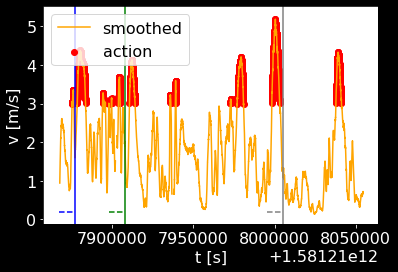

In [31]:
#for now, just do some manually
#future work: annotate this automatically
plt.plot(dfroll.head(headind).timestamp, dfroll.head(headind).v, label="smoothed", color="orange")
plt.scatter(dfsmall[dfsmall.v>3].timestamp, dfsmall[dfsmall.v>3].v, label="action", color="red")

#2pt shot
plt.axvline(x=1581217876835, color="blue")
plt.plot([1581217876835-10**4,1581217876835], [0.2, 0.2], color="blue", linestyle="--")
#3pt shot
plt.axvline(x=1581217907694, color="green")
plt.plot([1581217907694-10**4,1581217907694], [0.2, 0.2], color="green", linestyle="--")
#transition
plt.axvline(x=1581218005251, color="grey")
plt.plot([1581218005251-10**4,1581218005251], [0.2, 0.2], color="grey", linestyle="--")

plt.xlabel("t [s]")
plt.ylabel("v [m/s]")
plt.legend()
plt.show()


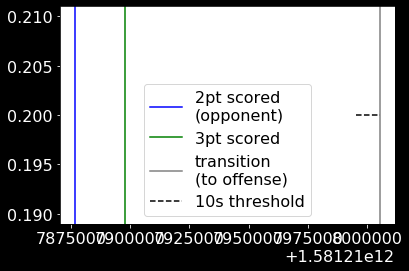

In [32]:
#just the legend
plt.axvline(x=1581217876835, color="blue", label="2pt scored\n(opponent)")
#3pt shot
plt.axvline(x=1581217907694-10000, color="green", label="3pt scored")
#transition
plt.axvline(x=1581218005251, color="grey", label="transition\n(to offense)")
plt.plot([1581218005251-10**4,1581218005251], [0.2, 0.2], color="black", linestyle="--", label="10s threshold")
plt.legend()
plt.show()
